# K-Means Clustering

# 1) Use the "Breast Cancer Wisconsin (Diagnostic) Data Set" from Kaggle to try and cluster types of cancer cells. 

Here's the original dataset for your reference:

<https://www.kaggle.com/uciml/breast-cancer-wisconsin-data>

## This is a supervised learning dataset

(Because it has **labels** - The "diagnosis" column.)

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # You don't necessarily have to use this
from sklearn.cluster import KMeans # You don't necessarily have to use this
from sklearn.preprocessing import StandardScaler # You don't necessarily have to use this

original = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Cancer_Cells.csv")
print(original.shape)
original.head()

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [0]:
# There's an unnamed column at the end with all NaN's, drop it
original = original.dropna(how='all', axis=1)

## Now it's an unsupervised learning dataset

(Because we've removed the diagnosis label) - Use this version.

In [74]:
# drop what we're trying to predict
df = original.drop('diagnosis', axis=1)

# drop the id column
df = df.drop('id', axis=1)
df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Let's do it!

- You might want to do some data exploration to see if you can find specific columns that will help you find distinct clusters of cells
- You might want to use the elbow method to decide on the number of clusters to use.


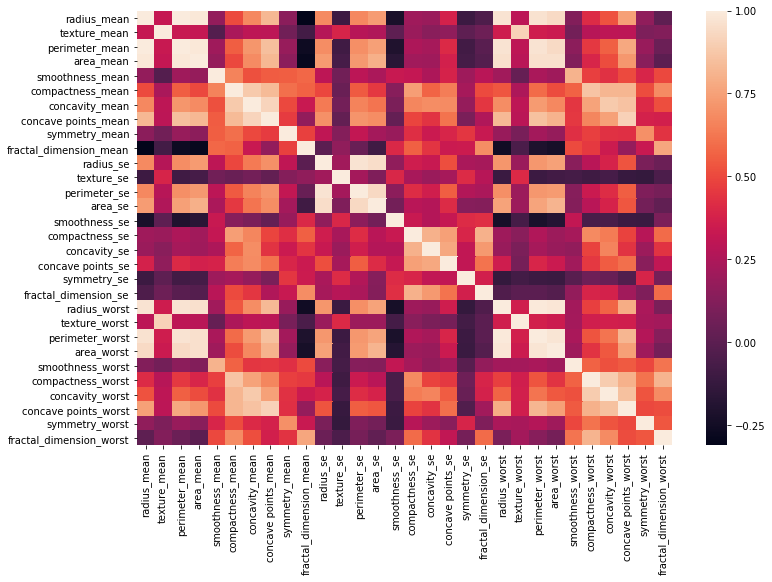

In [75]:
import seaborn as sns

# view a correlation heatmap, not needed for K-means but it's interesting
plt.figure().set_size_inches(12, 8)
sns.heatmap(df.corr())

In [0]:
# Elbow method to determine number of clusters 
# (copied from lecture, then changed to a function)
def plot_elbow_method(data):
  sum_of_squared_distances = []
  K = range(1,15)
  for k in K:
      km = KMeans(n_clusters=k)
      km = km.fit(data)
      sum_of_squared_distances.append(km.inertia_)

  plt.plot(K, sum_of_squared_distances, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Sum_of_squared_distances')
  plt.title('Elbow Method For Optimal k')
  plt.show()

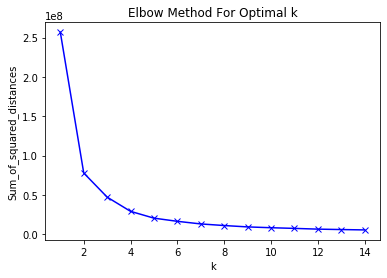

In [77]:
plot_elbow_method(df)

In [78]:
# Perform K-Means Clustering on the Dataset
kmeans = KMeans(n_clusters=2)
kmeans.fit(df)

# Save the cluster result to a new column
df['cluster'] = kmeans.labels_
df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,cluster
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


In [79]:
# how many rows did it put in each cluster?
df['cluster'].value_counts()

0    438
1    131
Name: cluster, dtype: int64

## Check you work: 

This is something that in a truly unsupervised learning situation **WOULD NOT BE POSSIBLE**. But for educational purposes go back and grab the true diagnosis column (label) from the original dataset. Take your cluster labels and compare them to the original diagnosis column. You can make scatterplots for each to see how they compare or you can calculate a percent accuracy score like: 
\begin{align}
\frac{\text{Num Correct Labels}}{\text{Num Total Observations}}
\end{align}

In [0]:
from sklearn.metrics import confusion_matrix

# I'm going to do this again later, so define a function now

def get_confusion_matrix(results):
  """
  returns a confusion matrix of the results

  pass in the resulting cluster array
  """
  # map cluster results to the diagnosis values
  # assuming cluster 0 is B and cluster 1 is M
  mapped = results.replace({0:'B', 1:'M'})

  # save to a dataframe and return it
  return pd.DataFrame(confusion_matrix(original['diagnosis'], mapped), 
                      index = ['actual_B','actual_M'], 
                      columns = ['pred_B','pred_M'])

In [80]:
get_confusion_matrix(df['cluster'])

,pred_B,pred_M
actual_B,356,1
actual_M,82,130


In [81]:
# alternate possibility if the clusters ended up the other way around
pd.DataFrame(confusion_matrix(original['diagnosis'], 
                              df['cluster'].replace({0:'M', 1:'B'})), 
             index = ['actual_B','actual_M'], 
             columns = ['pred_B','pred_M'])

,pred_B,pred_M
actual_B,1,356
actual_M,130,82


# 2) Perform PCA on your dataset first and *then* use k-means clustering. 

- You need to standardize your data before PCA.
- First try clustering just on PC1 and PC2 so that you can make a scatterplot of your clustering.
- Then use use a scree plot to decide how many principal components to include in your clustering, and use however many principal components you need in order to retain 90% of the variation of the original dataset



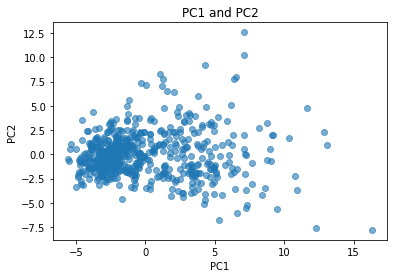

In [83]:
# standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(original.drop(['id', 'diagnosis'], axis=1))

# run PCA
pca = PCA(.9)
pca_features = pca.fit_transform(df_scaled)

# graph results
plt.scatter(x=pca_features.T[0], y=pca_features.T[1], alpha=.6)
plt.title('PC1 and PC2')
plt.xlabel('PC1')
plt.ylabel('PC2');

In [0]:
# copying the nice scree plot function from lecture
# Define scree plot function
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    #plt.figure(figsize=(18, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s" % ((str(vals[i]*100)[:3])), (ind[i], vals[i]), va="bottom", ha="center", fontsize=6)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

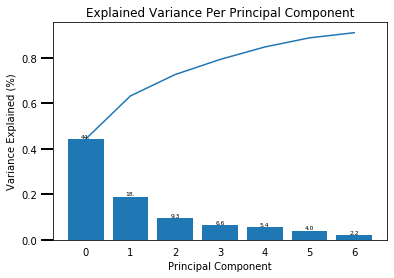

In [84]:
scree_plot(pca)

In [88]:
# Apply K clustering, try first 2 components first

# use slice to fit kmeans on just the first two components
kmeans.fit(pca_features[:,0:2])

# save results
two_PC_result = pd.DataFrame(pca_features[:,0:2])
two_PC_result['cluster'] = kmeans.labels_

# compare
mat = get_confusion_matrix(two_PC_result['cluster'])
print('Percentage correct:',(mat.iloc[0,0] + mat.iloc[1,1])/mat.sum().sum())
mat

Percentage correct: 0.9068541300527241


,pred_B,pred_M
actual_B,341,16
actual_M,37,175


In [89]:
# Try again with 90% of the variance (8 PC's)
kmeans.fit(pca_features)
eight_PC_result = pd.DataFrame(pca_features)
eight_PC_result['cluster'] = kmeans.labels_

# compare
mat = get_confusion_matrix(eight_PC_result['cluster'])
print('Percentage correct:',(mat.iloc[0,0] + mat.iloc[1,1])/mat.sum().sum())
mat

Percentage correct: 0.9103690685413005


,pred_B,pred_M
actual_B,343,14
actual_M,37,175


In [90]:
# Show the results we got from using K-means without PCA again
# This used the original 31 columns (33 minus diagnosis and the null column)
mat = get_confusion_matrix(df['cluster'])
print('Percentage correct:',(mat.iloc[0,0] + mat.iloc[1,1])/mat.sum().sum())
mat

Percentage correct: 0.8541300527240774


,pred_B,pred_M
actual_B,356,1
actual_M,82,130


## Check your work: 

- Compare your PC1, PC2 clustering scatterplot to the clustering scatterplots you made on the raw data
- Calculate accuracy scores for both the PC1,PC2 Principal component clustering and the 90% of explained variance clustering.

How do your accuracy scores -when preprocessing the data with PCA- compare to the accuracy when simply clustering on the raw data?

My results are all shown in the above three code cells:

- K-means on all raw data: 85.41% accuracy
- K-means on first 2 PC's: 90.69% accuracy
- K-means on 7 PC's (90% of the variance): 91.04% accuracy

- I had forgotten to drop the unique id column at first, K-means on all raw data with that included only had 62.57% accuracy

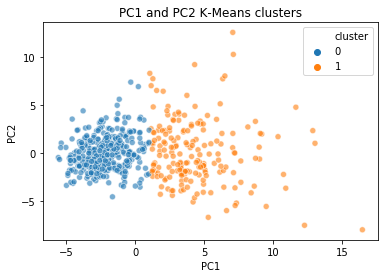

In [59]:
# for my curiosity, graph 2 PC results with acutal diagnosis values
sns.scatterplot(x=two_PC_result[0], y=two_PC_result[1], 
                hue=two_PC_result['cluster'], alpha=.6)
plt.title('PC1 and PC2 K-Means clusters')
plt.xlabel('PC1')
plt.ylabel('PC2');

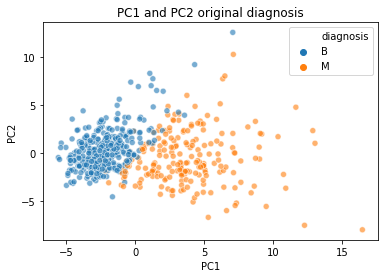

In [60]:
# hue order may or may not match, depending on which cluster ended up 1 or 0
sns.scatterplot(x=two_PC_result[0], y=two_PC_result[1], 
                hue=original['diagnosis'], hue_order=['B','M'], alpha=.6)
plt.title('PC1 and PC2 original diagnosis')
plt.xlabel('PC1')
plt.ylabel('PC2');

# Stretch Goals:

- Study for the Sprint Challenge
- Work on your Data Storytelling Project